In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs


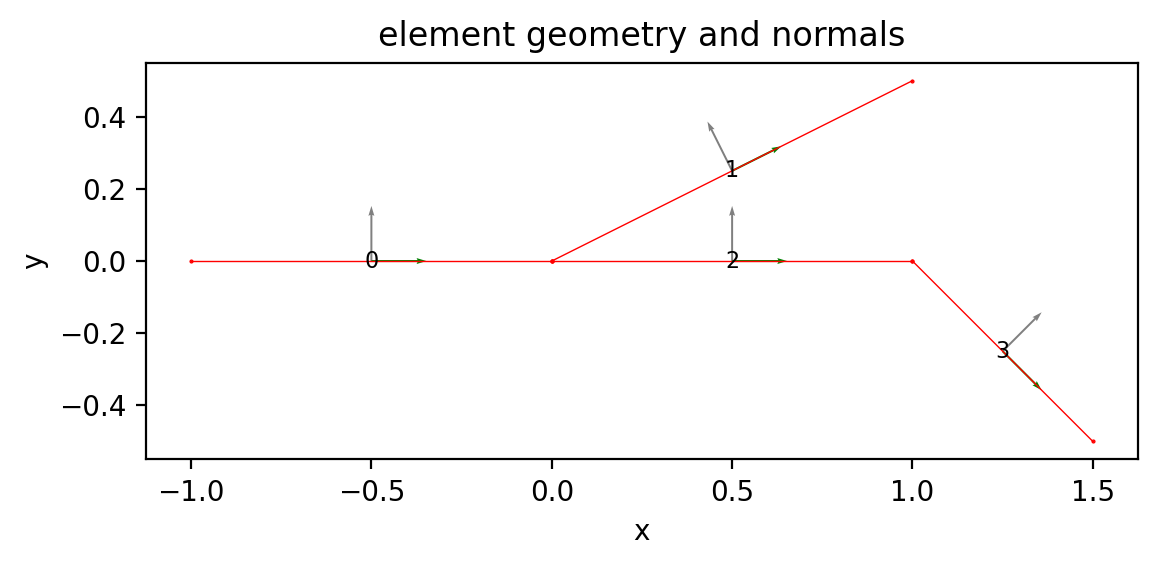

In [2]:
# Elastic parameters
mu = 1
nu = 0.25

# Model geometry
els = bemcs.initialize_els()
els.x1 = np.array([-1.0, 0.0, 0.0, 1.0])
els.x2 = np.array([0.0, 1.0, 1.0, 1.5])
els.y1 = np.array([0.0, 0.0, 0.0, 0.0])
els.y2 = np.array([0.0, 0.5, -0.0, -0.5])
bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)

# Slip vector
slip_vector_x = np.array([1.0, 0.5, 0.5, 0.2])
slip_vector_y = np.array([0.0, 0.0, 1.0, 0.0])

In [3]:
# Observation point
n_obs = 100
width = 2
x_obs = np.linspace(-width, width, n_obs)
y_obs = np.linspace(-width / 2, width / 2, n_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu, nu, flag="shear"
)
kernels_n = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu, nu, flag="normal"
)

### Boundary Conditions and Design Matrix

The number of equations for a given system with $N$ fault elements can be calculated as follows:
1. $2N$ equations for the central node of every element
2. $2N_o$ equations at the open nodes, where $N_o$ is the number of nodes that belong to only 1 fault element
3. $4N_i$ equations applied at $N_i$ interior nodes, where an interior node is any node that is shared by exactly 2 fault elements. 
4. $6N_t$ equations at triple junctions where $N_t$ is the number of triple junctions.

There are $6N$ unknown $3qn$ coefficients we need to solve for. Below we discuss the shape of the design matrix for a few typical cases:
- When the domain is a simply connected closed loop, there are no open nodes and no triple junctions, we have
  - $2N$ equations for the central node, $4N$ equations at the interior nodes
- When the domain is an open loop, there are $2$ open nodes at the ends of the mesh and we have
  - $2N$ equations for the central node, $4N-4$ equations at the interior nodes, $4$ equations at the open nodes
- For the case considered in this example,we have $2N$ equations for the central node, $6$ equations at the open nodes and $6$ equations at the triple junction, and the rest are for any other interior nodes (2-element overlaps)


## Labeling Nodes as Open, 2-overlap or triple junctions

We first go through all the end nodes of our mesh ($(x_1,y_1) \cup (x_2,y_2)$), find the unique ones and then label them as open, an interior node (overlap of exactly 2 elements) or a triple junction. We construct our boundary conditions and linear opeartor accordingly.

In [4]:
# first find all unique points
points = np.vstack(
    (
        np.hstack((els.x1.reshape(-1, 1), els.y1.reshape(-1, 1))),
        np.hstack((els.x2.reshape(-1, 1), els.y2.reshape(-1, 1))),
    )
)

unique_points, id_unique = np.unique(points, axis=0, return_index=True)

# find number of open, 2-overlap & triple junction nodes
index_matrix1 = []
index_matrix2 = []
index_matrix3 = []

for i in range(len(unique_points)):
    pts = unique_points[i, :].reshape(1, -1)

    # which element(s) contains this point
    id1 = np.where(
        np.all(pts == np.hstack((els.x1.reshape(-1, 1), els.y1.reshape(-1, 1))), axis=1)
    )
    id2 = np.where(
        np.all(pts == np.hstack((els.x2.reshape(-1, 1), els.y2.reshape(-1, 1))), axis=1)
    )

    # the negative signs are for the triple junction equations
    # s_1 + s_2 + s_3 = 0 with the negative sign going to any 2 elements that are both id1 or id2
    if np.size(id1) == 2:
        id_combo = np.hstack((-id1[0] * 3, id2[0] * 3 + 2))
    elif np.size(id2) == 2:
        id_combo = np.hstack((id1[0] * 3, -(id2[0] * 3 + 2)))
    else:
        id_combo = np.hstack((id1[0] * 3, id2[0] * 3 + 2))

    if np.size(id_combo) == 1:
        index_matrix1.append(id_combo)
    elif np.size(id_combo) == 2:
        index_matrix2.append(id_combo)
    elif np.size(id_combo) == 3:
        index_matrix3.append(id_combo)
    else:
        raise ValueError("Cannot deal with more than 3 lines at a node")

print("Number of open nodes =", len(index_matrix1), ":", index_matrix1)
print("Number of 2-overlap nodes =", len(index_matrix2), ":", index_matrix2)
print("Number of triple junctions =", len(index_matrix3), ":", index_matrix3)

N_c = 2 * n_els  # central node equations
N_o = 2 * len(index_matrix1)  # open node equations
N_i = 4 * len(index_matrix2)  # overlapping node equations
N_t = 6 * len(index_matrix3)  # triple junction equations

Number of open nodes = 3 : [array([0]), array([5]), array([11])]
Number of 2-overlap nodes = 1 : [array([9, 8])]
Number of triple junctions = 1 : [array([-3, -6,  2])]


In [5]:
# Design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
matrix_slip, matrix_slip_gradient = bemcs.get_matrices_slip_slip_gradient(
    els, flag="node"
)
matrix_slip_mean, _ = bemcs.get_matrices_slip_slip_gradient(els, flag="mean")

# Nequations = N_c + N_o + N_i + N_t
Nequations = N_c + N_o + N_i + N_t
Nunknowns = 6 * n_els

# We will stack this with
# equations for the element centers
# equations at open nodes (RHS = 0)
# equations at overlapping nodes (RHS = 0)
# equations at triple junctions (RHS = 0)
BC_c = np.zeros((N_c, 1))  # these are the only non-zero entries
BC_o = np.zeros((N_o, 1))
BC_i = np.zeros((N_i, 1))
BC_t = np.zeros((N_t, 1))

# slip boundary condition for element centers
BC_c[0:N_c:2] = slip_vector_x.reshape((-1, 1))
BC_c[1:N_c:2] = slip_vector_y.reshape((-1, 1))

# stack all the BCs into 1 big vector
BCvector = np.vstack((BC_c, BC_o, BC_i, BC_t))

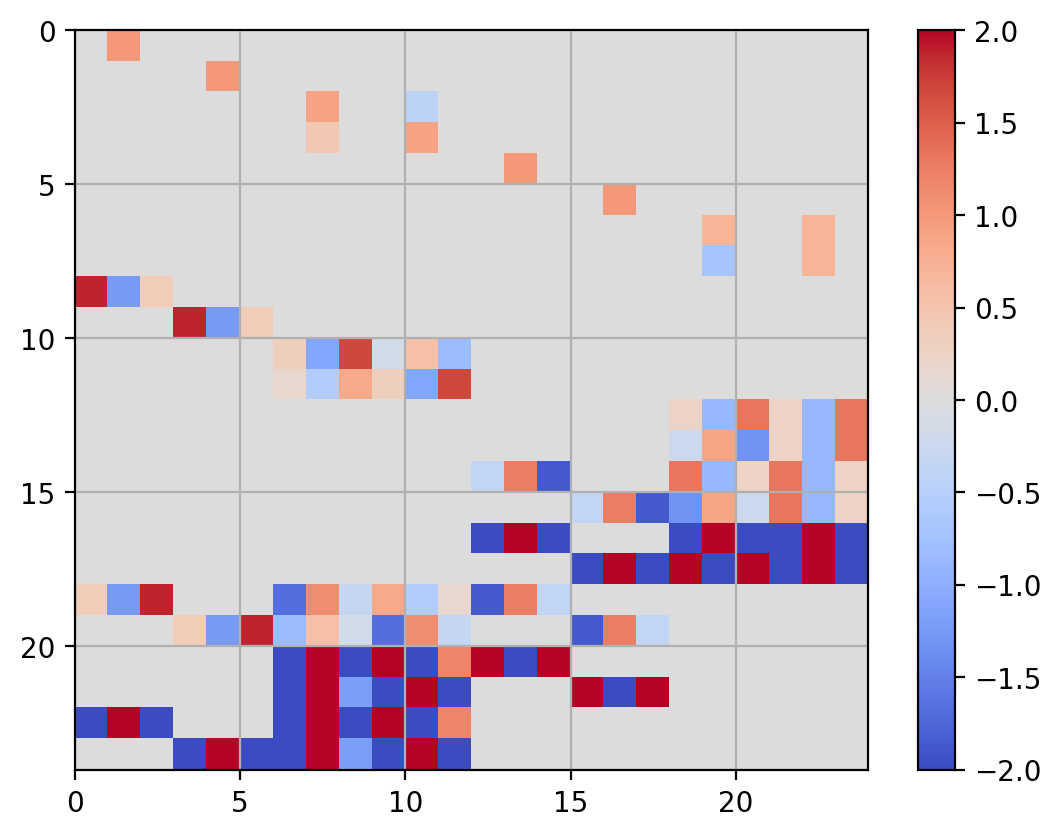

In [6]:
# Linear Operators for the appropriate boundary conditions
matrix_system_c = np.zeros((N_c, Nunknowns))
matrix_system_o = np.zeros((N_o, Nunknowns))
matrix_system_i = np.zeros((N_i, Nunknowns))
matrix_system_t = np.zeros((N_t, Nunknowns))

# Linear operator for central node BCs
matrix_system_c[0:N_c:2, :] = matrix_slip[2::6, :]  # x component
matrix_system_c[1:N_c:2, :] = matrix_slip[3::6, :]  # y component

# Linear operator for open nodes
for i in range(int(N_o / 2)):
    id1 = index_matrix1[i]  # node number
    matrix_system_o[2 * i, :] = matrix_slip[2 * id1, :]  # x component
    matrix_system_o[2 * i + 1, :] = matrix_slip[2 * id1 + 1, :]  # y component

# Linear operator for overlapping nodes
for i in range(int(N_i / 4)):
    idvals = index_matrix2[i]  # node number
    # continuity condition
    matrix_system_i[4 * i, :] = (
        matrix_slip[2 * idvals[0], :] - matrix_slip[2 * idvals[1], :]
    )  # x
    matrix_system_i[4 * i + 1, :] = (
        matrix_slip[2 * idvals[0] + 1, :] - matrix_slip[2 * idvals[1] + 1, :]
    )  # y
    # smoothing constraints
    matrix_system_i[4 * i + 2, :] = (
        matrix_slip_gradient[2 * idvals[0], :] - matrix_slip_gradient[2 * idvals[1], :]
    )  # x
    matrix_system_i[4 * i + 3, :] = (
        matrix_slip_gradient[2 * idvals[0] + 1, :]
        - matrix_slip_gradient[2 * idvals[1] + 1, :]
    )  # y


# Linear operator for triple junction nodes
for i in range(int(N_t / 6)):
    id1 = index_matrix3[i]
    idvals = np.abs(id1)

    id_neg = idvals[id1 < 0]  # node number that need to be subtracted in TJ kinematics
    id_pos = idvals[id1 >= 0]  # node numbers that need to be added
    # triple junction kinematics equations
    if len(id_neg) == 2:
        matrix_system_t[6 * i, :] = (
            matrix_slip[2 * id_pos, :]
            - matrix_slip[2 * id_neg[0], :]
            - matrix_slip[2 * id_neg[1], :]
        )  # x component
        matrix_system_t[6 * i + 1, :] = (
            matrix_slip[2 * id_pos + 1, :]
            - matrix_slip[2 * id_neg[0] + 1, :]
            - matrix_slip[2 * id_neg[1] + 1, :]
        )  # y component
    else:
        matrix_system_t[6 * i, :] = (
            matrix_slip[2 * id_pos[0], :]
            + matrix_slip[2 * id_pos[1], :]
            - matrix_slip[2 * id_neg, :]
        )  # x component
        matrix_system_t[6 * i + 1, :] = (
            matrix_slip[2 * id_pos[0] + 1, :]
            + matrix_slip[2 * id_pos[1] + 1, :]
            - matrix_slip[2 * id_neg + 1, :]
        )  # y component

    # smoothing constraints (2 nodes at a time)
    matrix_system_t[6 * i + 2, :] = (
        matrix_slip_gradient[2 * idvals[0], :] - matrix_slip_gradient[2 * idvals[1], :]
    )  # x
    matrix_system_t[6 * i + 3, :] = (
        matrix_slip_gradient[2 * idvals[0] + 1, :]
        - matrix_slip_gradient[2 * idvals[1] + 1, :]
    )  # y
    matrix_system_t[6 * i + 4, :] = (
        matrix_slip_gradient[2 * idvals[0], :] - matrix_slip_gradient[2 * idvals[2], :]
    )  # x
    matrix_system_t[6 * i + 5, :] = (
        matrix_slip_gradient[2 * idvals[0] + 1, :]
        - matrix_slip_gradient[2 * idvals[2] + 1, :]
    )  # y

# stack the matrices and create the full linear operator
matrix_system = np.vstack(
    (matrix_system_c, matrix_system_o, matrix_system_i, matrix_system_t)
)

# plot design matrix
_, ax = plt.subplots()
pc = ax.pcolor(matrix_system, cmap="coolwarm", shading="flat")
ax.grid(which="both")
ax.invert_yaxis()
pc.set_clim(-2, 2)
plt.colorbar(pc)
plt.show()

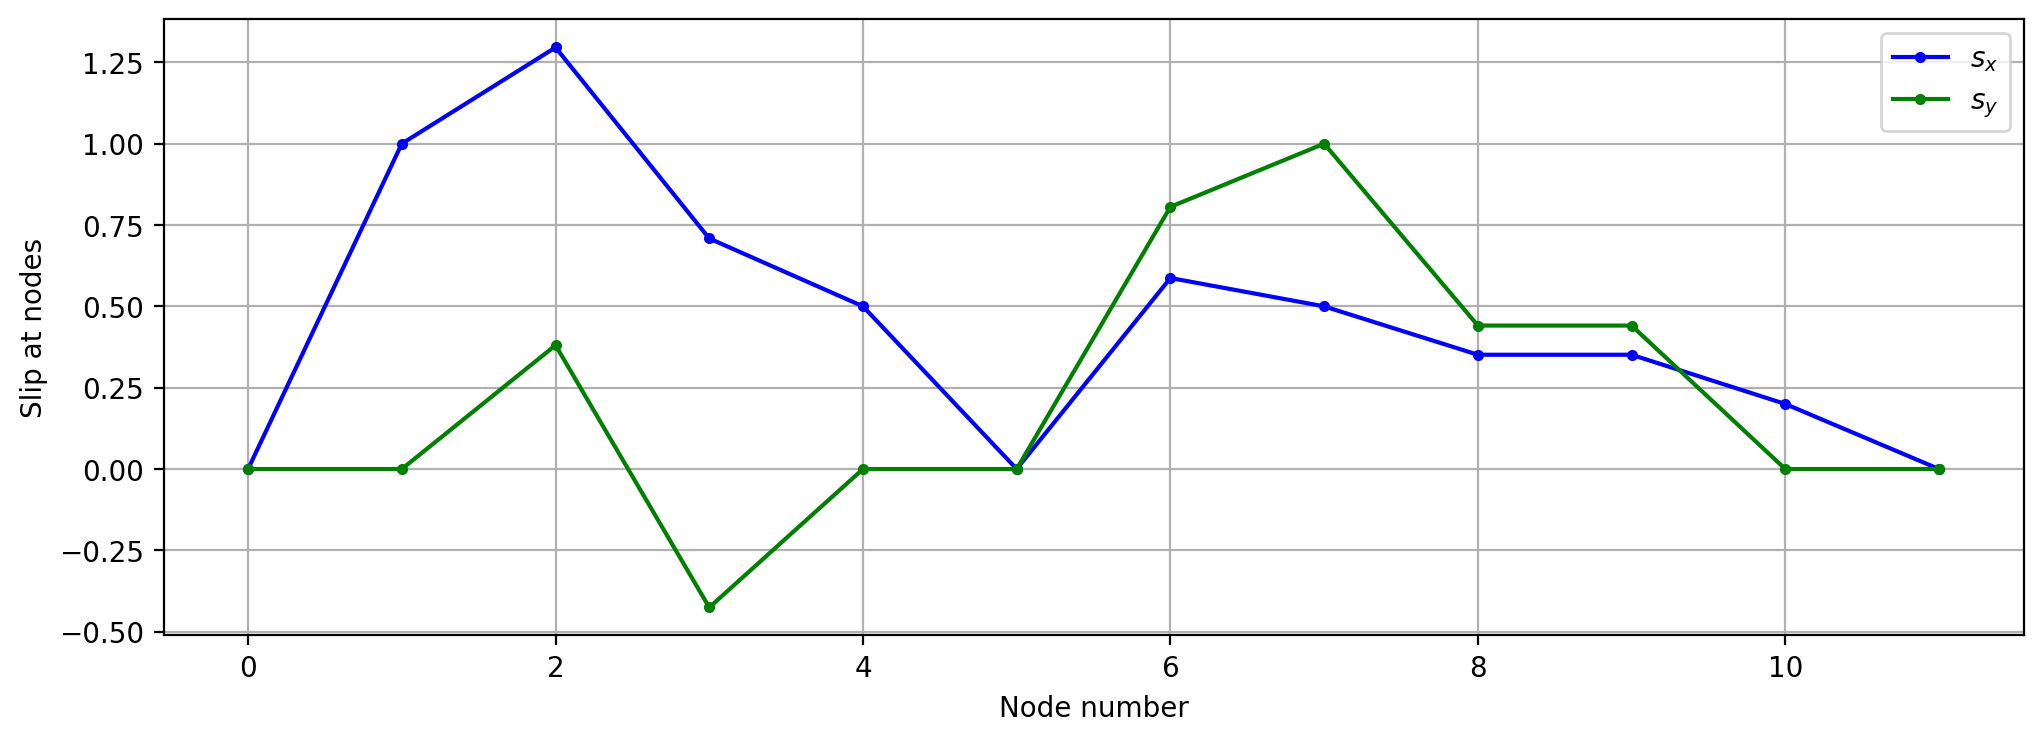

[[ 1.29577901  0.38047271]
 [ 0.70865368 -0.42538142]
 [ 0.58712533  0.80585412]]


In [7]:
# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.inv(matrix_system) @ BCvector
# quadratic_coefs = np.linalg.lstsq(matrix_system,BCvector)[0]

# print(matrix_system@quadratic_coefs - BCvector)

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((3 * n_els, 1))
quadratic_coefs_n = np.zeros((3 * n_els, 1))
for i in range(n_els):
    quadratic_coefs_s[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i : 6 * i + 3]
    quadratic_coefs_n[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i + 3 : 6 * (i + 1)]

# extract slip at nodes from quadratic coefficients
slip_nodes = matrix_slip @ quadratic_coefs
slip_nodes_x = slip_nodes[0::2]
slip_nodes_y = slip_nodes[1::2]
slip_vector = np.hstack((slip_nodes_x, slip_nodes_y))
# rotate from (x,y) to (s,n) for slip vector
slip_nodes_s = np.zeros((3 * n_els, 1))
slip_nodes_n = np.zeros((3 * n_els, 1))

for i in range(n_els):
    dummy = slip_vector[3 * i : 3 * (i + 1), :] @ els.rot_mats[i, :, :]
    slip_nodes_s[3 * i : 3 * (i + 1), 0] = dummy[:, 0]
    slip_nodes_n[3 * i : 3 * (i + 1), 0] = dummy[:, 1]

xnodes = np.zeros((3 * n_els, 1))
xnodes[0::3, 0] = els.x1
xnodes[2::3, 0] = els.x2
xnodes[1::3, 0] = 0.5 * (els.x1 + els.x2)

plt.figure(figsize=(12, 4))
plt.plot(slip_nodes_x, "b.-", label="$s_x$")
plt.plot(slip_nodes_y, "g.-", label="$s_y$")
plt.xlabel("Node number")
plt.ylabel("Slip at nodes")
plt.legend()
plt.grid()
plt.show()

print(np.hstack((slip_nodes_x[[2, 3, 6]], slip_nodes_y[[2, 3, 6]])))

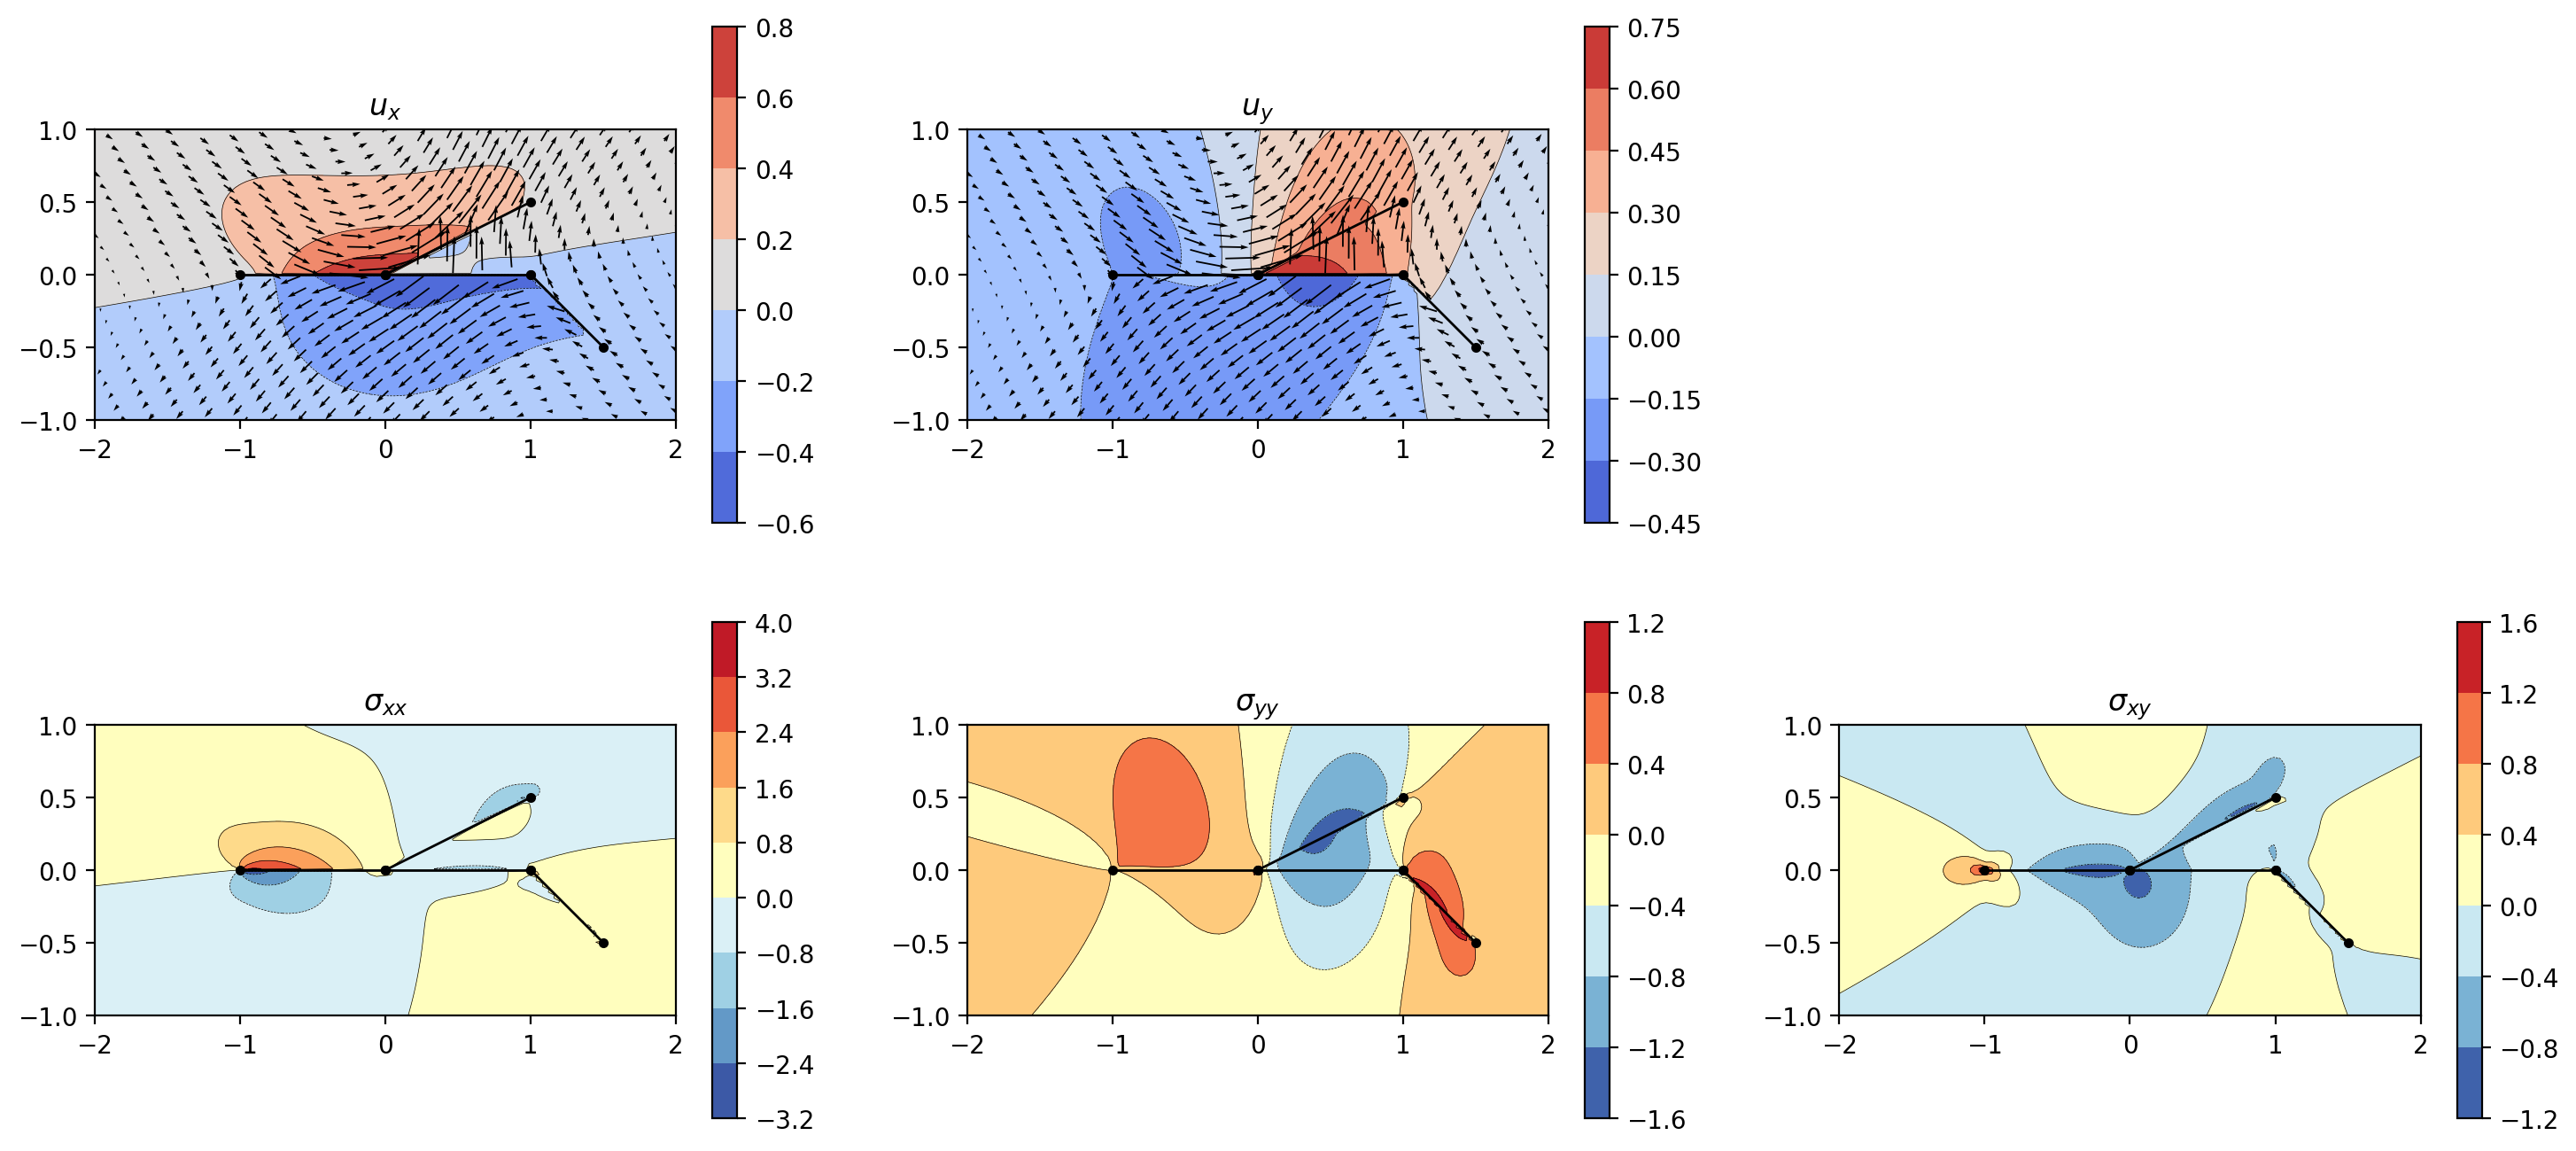

In [8]:
# Compute displacement and stresses (we will plot it later)
ux = kernels_s[3] @ quadratic_coefs_s + kernels_n[3] @ quadratic_coefs_n
uy = kernels_s[4] @ quadratic_coefs_s + kernels_n[4] @ quadratic_coefs_n
sxx = kernels_s[0] @ quadratic_coefs_s + kernels_n[0] @ quadratic_coefs_n
syy = kernels_s[1] @ quadratic_coefs_s + kernels_n[1] @ quadratic_coefs_n
sxy = kernels_s[2] @ quadratic_coefs_s + kernels_n[2] @ quadratic_coefs_n

bemcs.plot_displacements_stresses_els(
    els, n_obs, ux, uy, sxx, syy, sxy, x_obs, y_obs, n_skip_plot=21
)

/Users/meade/Desktop/bemcs/bemcs/bemcs.py:475: RuntimeWarning: divide by zero encountered in divide
  arctan_x_minus_a = np.pi / 2 * np.sign(y / (a - x)) - np.arctan(y / (a - x))
/Users/meade/Desktop/bemcs/bemcs/bemcs.py:1009: RuntimeWarning: divide by zero encountered in divide
  3
/Users/meade/Desktop/bemcs/bemcs/bemcs.py:1087: RuntimeWarning: divide by zero encountered in divide
  1
/Users/meade/Desktop/bemcs/bemcs/bemcs.py:1160: RuntimeWarning: divide by zero encountered in divide
  -3
/Users/meade/Desktop/bemcs/bemcs/bemcs.py:1239: RuntimeWarning: divide by zero encountered in divide
  -3
/Users/meade/Desktop/bemcs/bemcs/bemcs.py:1330: RuntimeWarning: divide by zero encountered in divide
  1
/Users/meade/Desktop/bemcs/bemcs/bemcs.py:1414: RuntimeWarning: divide by zero encountered in divide
  -3
/Users/meade/Desktop/bemcs/bemcs/bemcs.py:1752: RuntimeWarning: invalid value encountered in multiply
  ) + 2 * y_component * mu * (-f[4, :] + y * f[6, :])
/Users/meade/Desktop/bemcs/bemcs

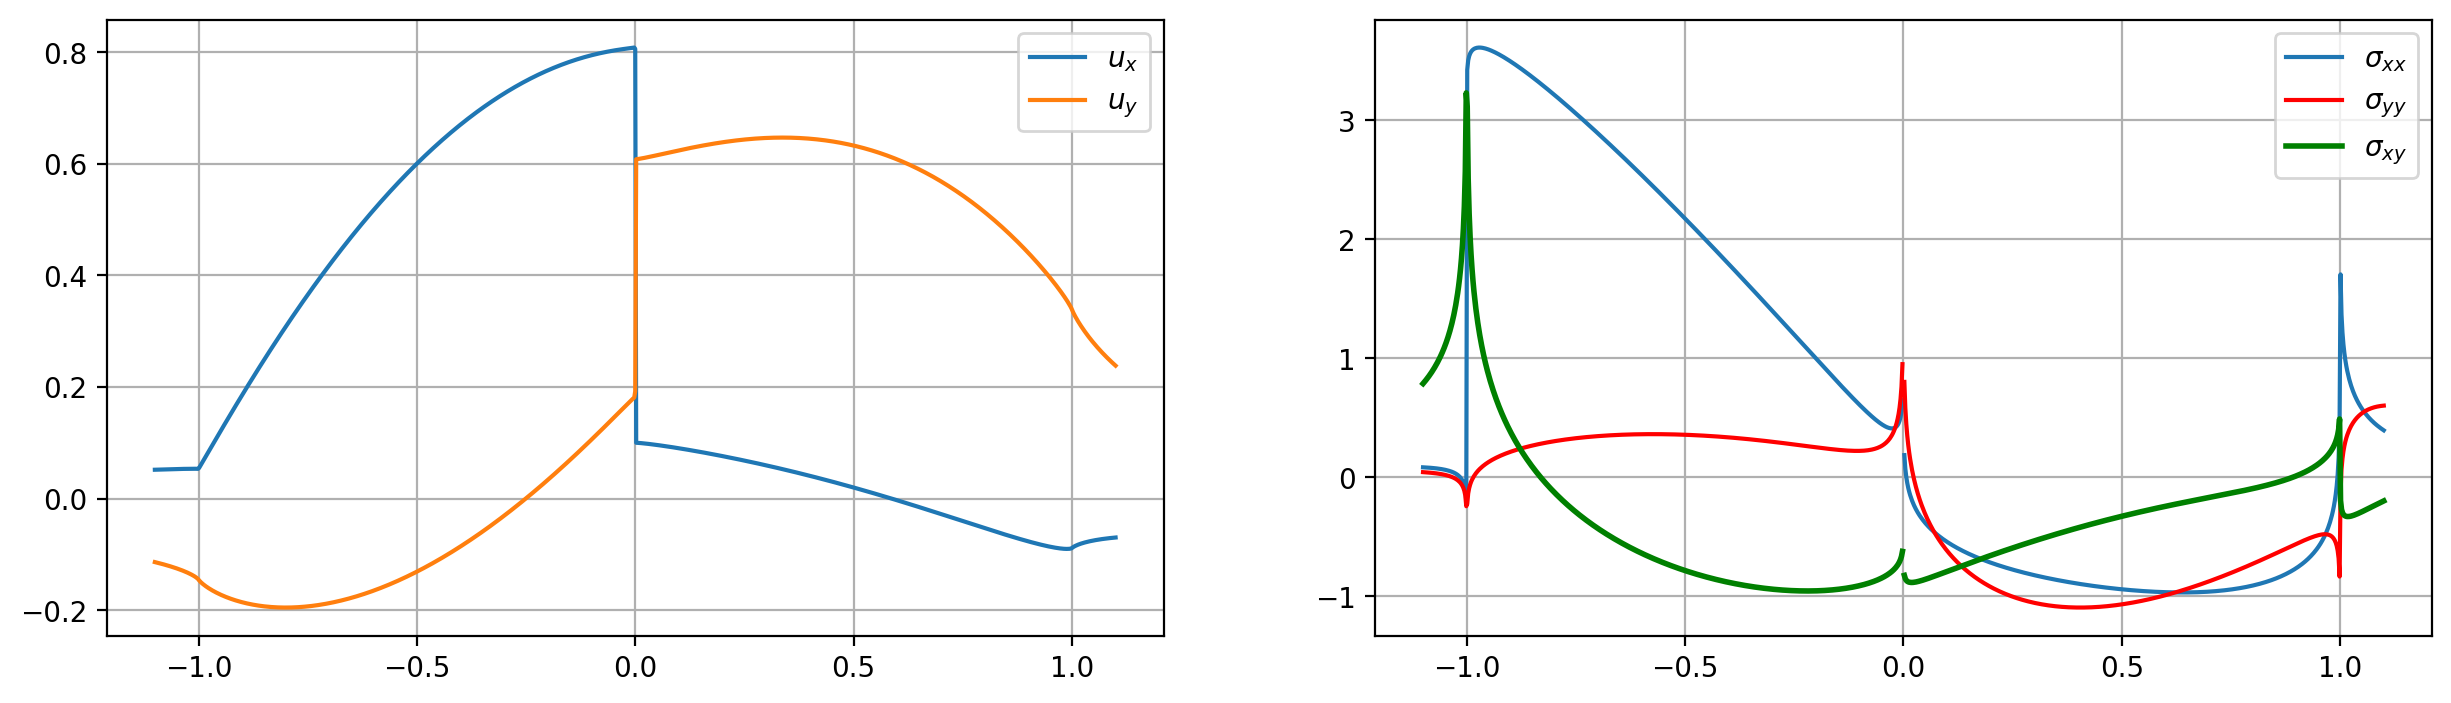

/Users/meade/Desktop/bemcs/bemcs/bemcs.py:1239: RuntimeWarning: invalid value encountered in divide
  -3
/Users/meade/Desktop/bemcs/bemcs/bemcs.py:1330: RuntimeWarning: invalid value encountered in divide
  1
/Users/meade/Desktop/bemcs/bemcs/bemcs.py:1414: RuntimeWarning: invalid value encountered in divide
  -3
/Users/meade/Desktop/bemcs/bemcs/bemcs.py:1751: RuntimeWarning: invalid value encountered in multiply
  2 * f[3, :] + y * f[5, :]


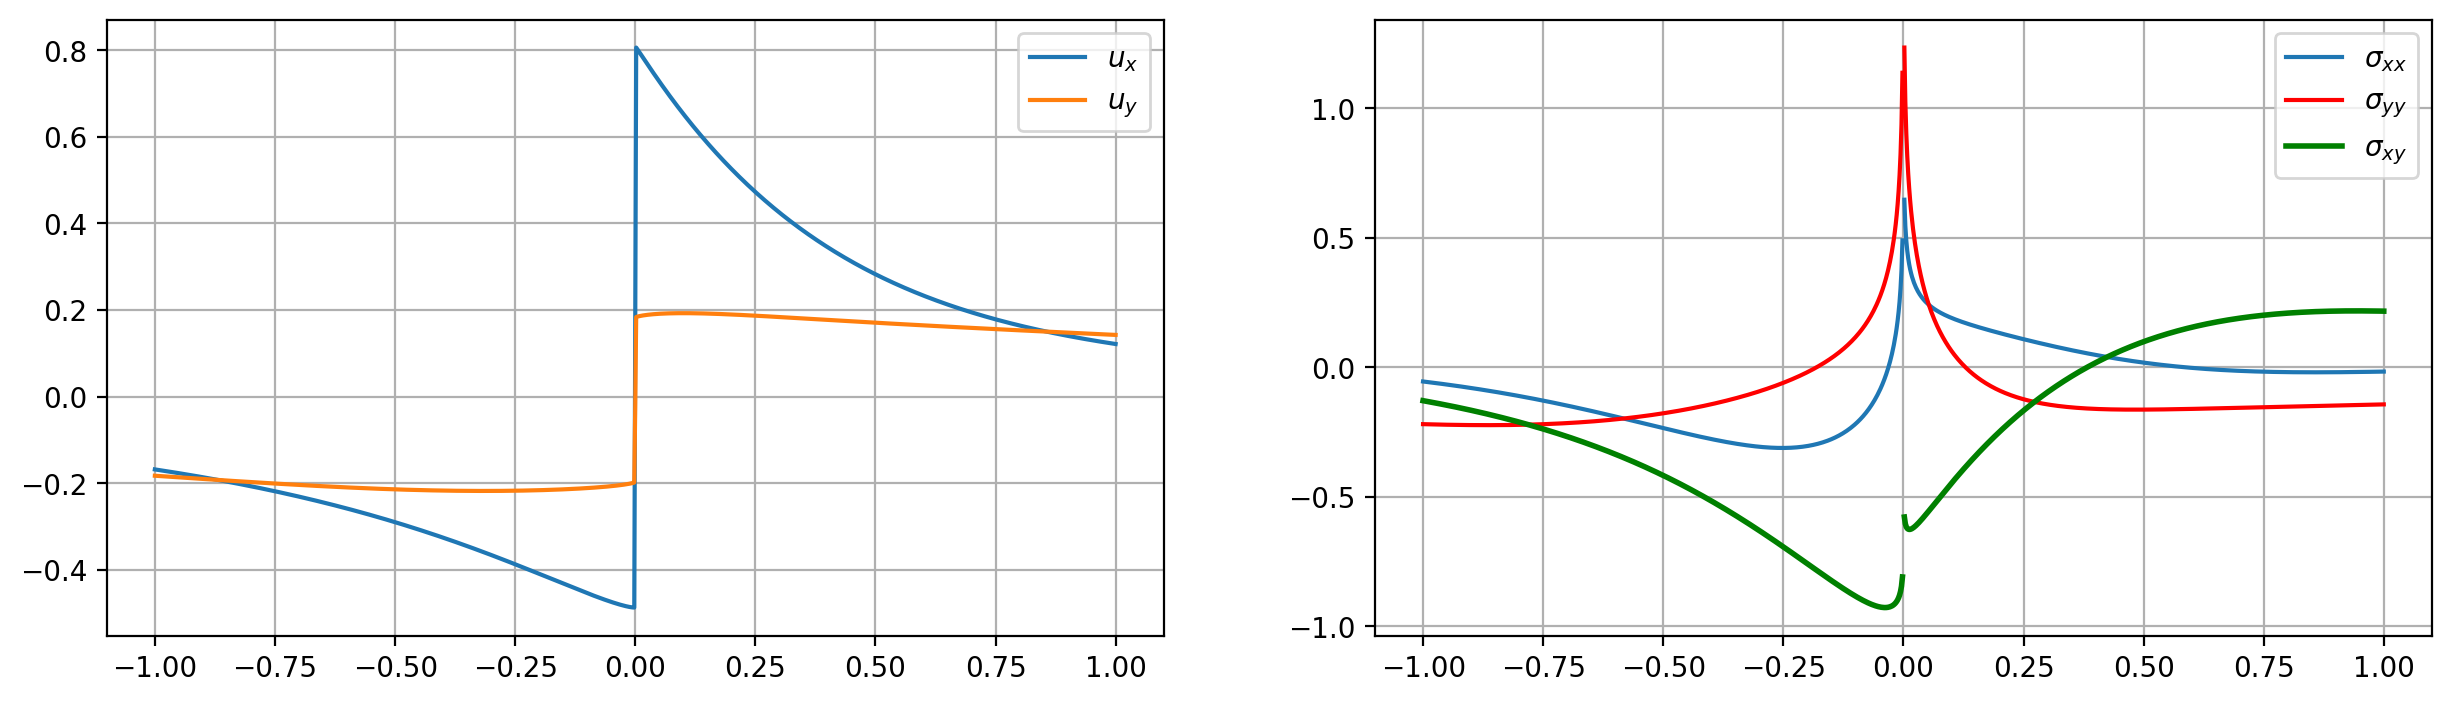

In [9]:
# Plot along x-axis
x_obs = np.linspace(-1.1, 1.1, 1001).reshape(-1, 1)
y_obs = 1e-8 + x_obs * 0

# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu, nu, flag="shear"
)
kernels_n = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu, nu, flag="normal"
)

# Compute displacement and stresses (we will plot it later)
ux = kernels_s[3] @ quadratic_coefs_s + kernels_n[3] @ quadratic_coefs_n
uy = kernels_s[4] @ quadratic_coefs_s + kernels_n[4] @ quadratic_coefs_n
sxx = kernels_s[0] @ quadratic_coefs_s + kernels_n[0] @ quadratic_coefs_n
syy = kernels_s[1] @ quadratic_coefs_s + kernels_n[1] @ quadratic_coefs_n
sxy = kernels_s[2] @ quadratic_coefs_s + kernels_n[2] @ quadratic_coefs_n

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(x_obs, ux, "-", label="$u_x$")
plt.plot(x_obs, uy, "-", label="$u_y$")
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x_obs, sxx, "-", label="$\sigma_{xx}$")
plt.plot(x_obs, syy, "r-", label="$\sigma_{yy}$")
plt.plot(x_obs, sxy, "g-", label="$\sigma_{xy}$", linewidth=2)
plt.legend()
plt.grid()
plt.show()

# plot along y-axis
y_obs = np.linspace(-1.0, 1.0, 1001).reshape(-1, 1)
x_obs = -1e-8 + y_obs * 0

# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu, nu, flag="shear"
)
kernels_n = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu, nu, flag="normal"
)

# Compute displacement and stresses (we will plot it later)
ux = kernels_s[3] @ quadratic_coefs_s + kernels_n[3] @ quadratic_coefs_n
uy = kernels_s[4] @ quadratic_coefs_s + kernels_n[4] @ quadratic_coefs_n
sxx = kernels_s[0] @ quadratic_coefs_s + kernels_n[0] @ quadratic_coefs_n
syy = kernels_s[1] @ quadratic_coefs_s + kernels_n[1] @ quadratic_coefs_n
sxy = kernels_s[2] @ quadratic_coefs_s + kernels_n[2] @ quadratic_coefs_n

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(y_obs, ux, "-", label="$u_x$")
plt.plot(y_obs, uy, "-", label="$u_y$")
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(y_obs, sxx, "-", label="$\sigma_{xx}$")
plt.plot(y_obs, syy, "r-", label="$\sigma_{yy}$")
plt.plot(y_obs, sxy, "g-", label="$\sigma_{xy}$", linewidth=2)
plt.legend()
plt.grid()
plt.show()